In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import time
import tensorflow as tf
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import AdaBoostClassifier as AdaBoost
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, plot_roc_curve, roc_curve, auc
from tensorflow import keras
%matplotlib inline

# CS5600 Final Project by Jeff Gradner
***
### About
The goal of this project and notebook is to compare the performance of supervised and unsupervised machine learning techniques in classifying whether treatment of an animal will be successful. The data I'm using can be found in `data/raw_data.csv` and is provided by a Utah feedlot operation.
***
### Preprocesing
I'll preprocess the data by adding calculated features, removing features, and performing feature engineering by normalization and standardization. 
***
### Visualization
I'll use Matplotlib to visualize and gain insight from the raw data, processed data and results from different algorithms.
***
### Algorithms
I'll use a variety of different techniques and apply cross-validation and hyperparameter tuning where applicable:
#### Supervised
* Random Forests (RF)
* AdaBoost
* Support Vector Machines (SVM)
* Logistic Regression
* Neural Networks (NN)

#### Unsupervised
* Gaussian Mixed Models (GMM)
* K-Means (KMeans)
* Primary Component Analysis (PCA)
* Kernel Primary Component Analysis (KPCA)
***
### Table of Contents

* [Raw Data Visualization](#rawDataVis)
* [Pre Processing](#preprocessing)
* [Splitting the Data](#splitting)
* [Supervised Algorithms](#supervised) 
    * [Random Forest](#rf)
    * [AdaBoost](#ada)
    * [Support Vecor Machine](#svm)
    * [Logistic Regression](#lr)
    * [Neural Network](#nn)
* [Unsupervised Algorithms](#unsupervised)
* [ROC Curves](#roc)

<a id="rawDataVis"></a>
# Raw Data Visualization

Below I'm reading the original data into a Pandas DataFrame and assign the dtype to each column based on observing the data in a spreadsheet.

In [115]:
df_raw = pd.read_csv('data/raw_data.csv', dtype={'yard.lot.tag.date':'object',
                                                            'Yard.Lot': 'object',
                                                            'yard.lot.tag':'object',
                                                            'Yard': 'string',
                                                            'Lot': 'string',
                                                            'Treat.Date':'string',
                                                            'Drug': 'string',
                                                            'Treat.Weight':'int64',
                                                            'Treat.Temperature':'float64',
                                                            'Sex': 'string',
                                                            'Treatment.Number':'int64',
                                                            'Head.Received': 'int64',
                                                            'Arrival.Date': 'string',
                                                            'Arrival.Weight':'float64',
                                                            'Death.Date':'object',
                                                            'Cause.Of.Death':'object'},)

## Plotting of the Raw Data

### Quantity of Deaths by Cause per Gender
I see that both male and female cows die majorily from respiratory problems and that more males die than females. H is for hefer and S is for steer.

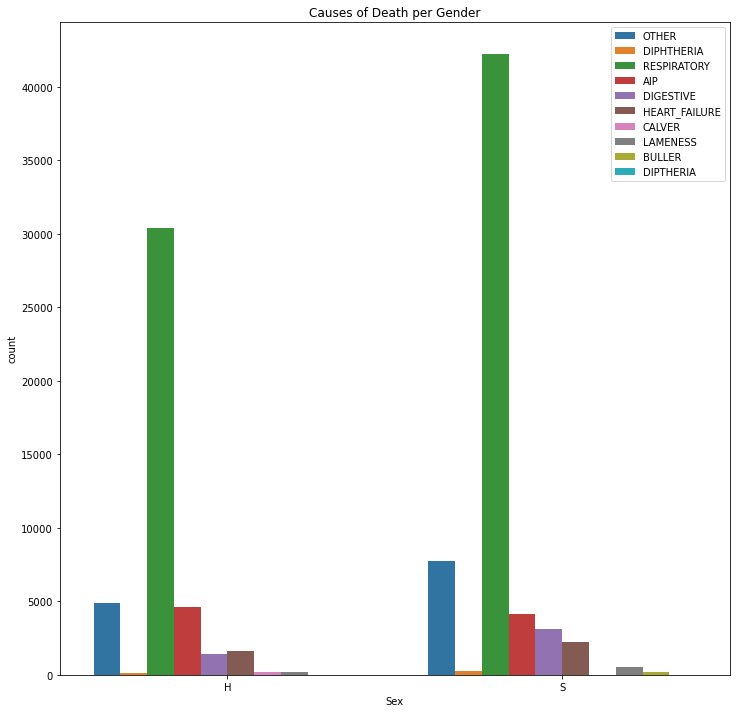

In [116]:
plt.figure(figsize=(12,12))
sns.countplot(x='Sex', hue ='Cause.Of.Death', data=df_raw)
plt.title('Causes of Death per Gender')
plt.legend(loc='best')
plt.show()

## Quantity of Causes of Death per Drug Type
I'm checking for the the largest causes of death, RESPIRATORY, AIP, and OTHER, how many die while being treated with a given drug. 

Below I'm filtering the data to only include examples where the cause of death is one of the 3 top contributors.

In [117]:
df_respiratory = df_raw.loc[df_raw['Cause.Of.Death'] == 'RESPIRATORY']
df_aip = df_raw.loc[df_raw['Cause.Of.Death'] == 'AIP']
df_other = df_raw.loc[df_raw['Cause.Of.Death'] == 'OTHER']
df_deaths_drugs = pd.concat([df_respiratory, df_aip, df_other], axis=0)

Plotting the number of deaths for each cause of death and with what treatment drug was used.

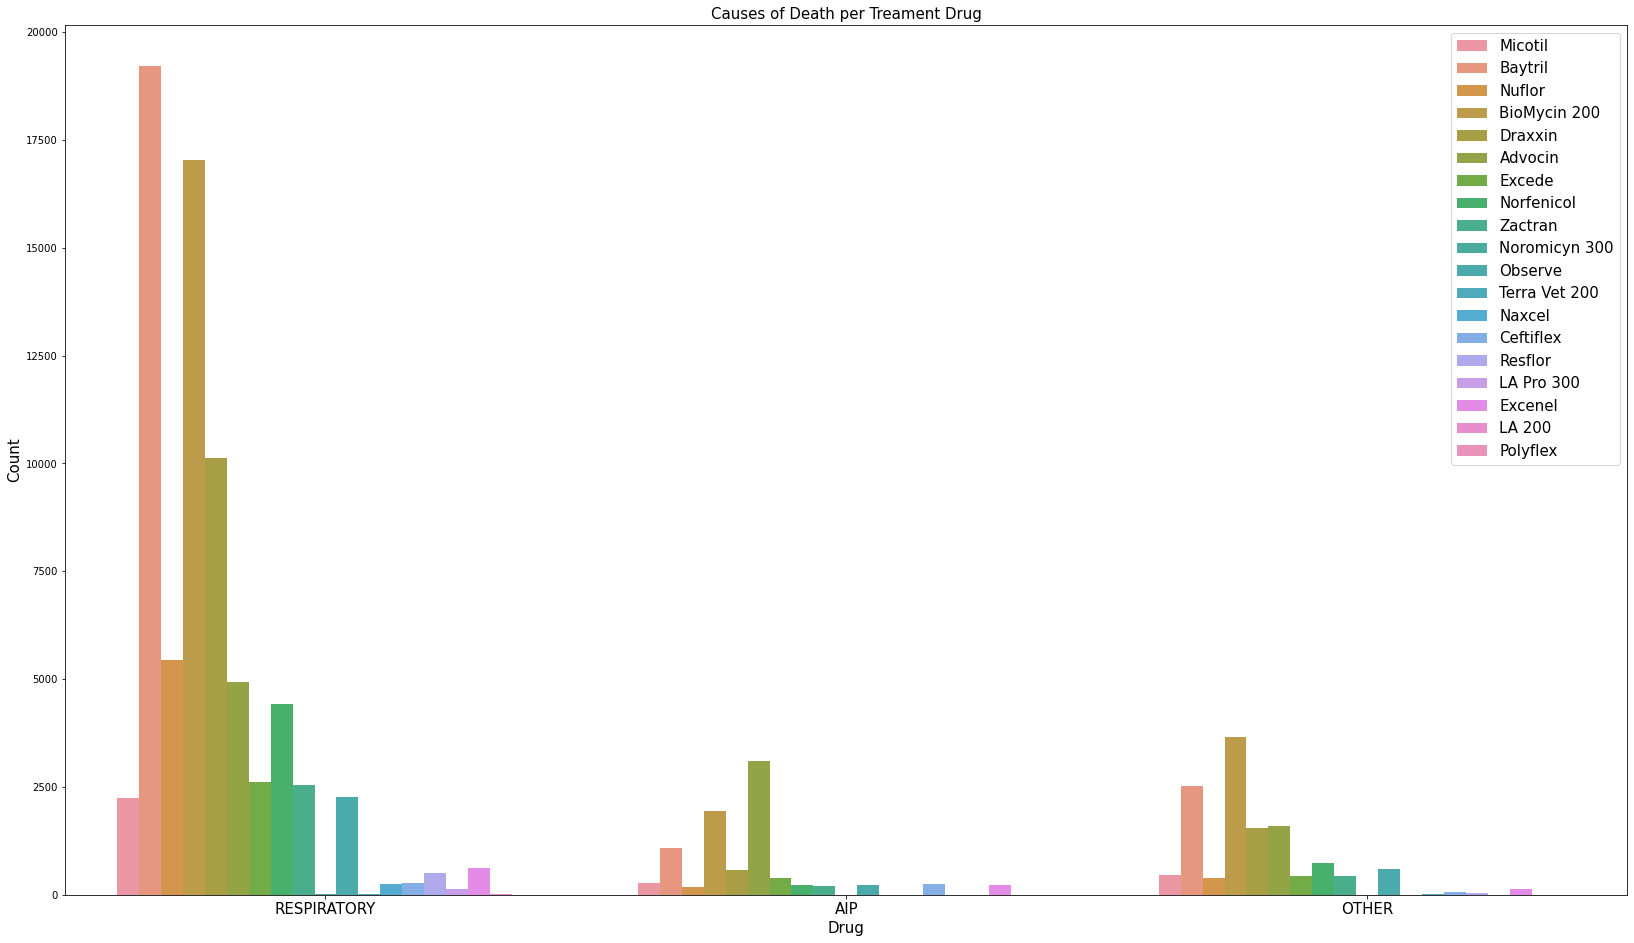

In [118]:
plt.figure(figsize=(28,16))
sns.countplot(x='Cause.Of.Death', hue ='Drug', data=df_deaths_drugs)
plt.title('Causes of Death per Treament Drug',fontsize=15)
plt.legend(loc='upper right',prop={'size':'15'})
plt.xlabel('Drug', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(fontsize=15)
plt.show()

## Raw Data Insights

Below is the shape of the original data and a sample of 3 examples.

In [119]:
print("Original data shape:", df_raw.shape)
df_raw.sample(3)

Original data shape: (637742, 16)


,yard.lot.tag.date,Yard.Lot,yard.lot.tag,Yard,Lot,Treat.Date,Drug,Treat.Weight,Treat.Temperature,Sex,Treatment.Number,Head.Received,Arrival.Date,Arrival.Weight,Death.Date,Cause.Of.Death
419198,1027.9176.2130151.2019-10-03,1027.9176,1027.9176.2130151,1027,9176,10/3/2019,BioMycin 200,936,102.0,H,1,545,7/21/2019,715.0,NaN,NaN
261502,1015.493.52584.2019-12-03,1015.493,1015.493.52584,1015,493,12/3/2019,Draxxin,1144,105.0,S,1,210,10/16/2019,931.0,NaN,NaN
574861,1032.2599.599609.2016-12-15,1032.2599,1032.2599.599609,1032,2599,12/15/2016,Nuflor,610,105.1,S,1,245,12/2/2018,793.0,NaN,NaN


I'm checking if there are any null values and how many of each there are. I see that there are missing values for the Death Date and Cause of Death, this makes sense because not every animal who is treated for Bovine Respiratory Disease dies.

In [120]:
df_raw.isna().sum()

yard.lot.tag.date         0
Yard.Lot                  0
yard.lot.tag              0
Yard                      0
Lot                       0
Treat.Date                0
Drug                      0
Treat.Weight              0
Treat.Temperature         0
Sex                       0
Treatment.Number          0
Head.Received             0
Arrival.Date              0
Arrival.Weight            0
Death.Date           533913
Cause.Of.Death       533913
dtype: int64

Checking how many deaths per Cause of Death. The majority of deaths reported are attributed to respiratory.

In [121]:
df_raw['Cause.Of.Death'].value_counts()

RESPIRATORY      72697
OTHER            12650
AIP               8704
DIGESTIVE         4493
HEART_FAILURE     3851
LAMENESS           663
DIPHTHERIA         388
BULLER             198
CALVER             180
DIPTHERIA            5
Name: Cause.Of.Death, dtype: int64

Viewing how many of each sex exist in the data. 

In [122]:
df_raw['Sex'].value_counts()

S    409015
H    228727
Name: Sex, dtype: Int64

Viewing descriptive statistics from the original data.

In [123]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Treat.Weight,637742.0,808.029455,212.499837,-1114.0,662.0,789.0,933.0,9955.0
Treat.Temperature,637742.0,104.402306,2.381540,1.0,103.9,104.4,105.1,678.0
Treatment.Number,637742.0,1.476127,0.837107,1.0,1.0,1.0,2.0,20.0
Head.Received,637742.0,232.000260,168.899591,1.0,138.0,202.0,278.0,2171.0
Arrival.Weight,637742.0,718.653705,139.315755,0.0,638.0,724.0,803.0,3482.0


<a id="preprocessing"></a>
# Pre-Processing

In [124]:
df_raw.sample(3)

,yard.lot.tag.date,Yard.Lot,yard.lot.tag,Yard,Lot,Treat.Date,Drug,Treat.Weight,Treat.Temperature,Sex,Treatment.Number,Head.Received,Arrival.Date,Arrival.Weight,Death.Date,Cause.Of.Death
9225,1001.8973.3938973.2018-05-02,1001.8973,1001.8973.3938973,1001,8973,5/2/2018,Nuflor,846,104.1,S,2,75,1/12/2018,719.0,NaN,NaN
229086,1011.ROD-84.2430.2012-07-01,1011.ROD-84,1011.ROD-84.2430,1011,ROD-84,7/1/2012,Draxxin,596,105.5,S,2,151,5/24/2012,521.0,NaN,NaN
173744,1008.929.57008.2019-08-08,1008.929,1008.929.57008,1008,929,8/8/2019,Advocin,1101,105.9,H,1,295,5/2/2019,804.0,8/14/2019,AIP


Feedlots are made up of yards that contain lots where the animals reside. Each animal has a unique tag. Below I'm taking the series of yard.lot.tag and splitting the data where there are periods to create three series for the yard, lot, and tag. I'm then combining yard and tag into one series named Yard.Tag adding it to the DataFrame and removing the yard and tag columns.

In [125]:
ylt = df_raw['yard.lot.tag']
ylt = ylt.str.split( '.', expand= True)
ylt.rename(columns = {0:'yard', 1:'lot', 2:'tag'}, inplace = True)
df_raw['yard'] = ylt['yard']
df_raw['tag'] = ylt['tag']
df_raw['Yard.Tag'] = df_raw['yard'] + '.' + df_raw['tag']
df_raw = df_raw.drop(['yard', 'tag'], axis = 1)

A target column doesn't exist in the raw data so I'm going to add one named DNF for Did Not Finish. If an example has 0 for its DNF value then the animal finished or lived. If DNF has a value of 1 then that animal died. I construct the DNF series by inserting the value 0 if there is no death date, otherwise 1.

In [126]:
df_raw['DNF'] = ''
df_raw['DNF'] = np.where(pd.isna(df_raw['Death.Date']), 0, 1)

Thinking that the time of year an animal arrives on the feedlot and gets sick could be useful I'm adding features for the arrival month and quarter, and the treat month and quarter. I'm using Pandas to parse the month and quarter from the exising arrival and treat dates. 

In [127]:
df_raw['Arrival.Month'] = pd.DatetimeIndex(df_raw['Arrival.Date']).month
df_raw['Arrival.Quarter'] = pd.DatetimeIndex(df_raw['Arrival.Date']).quarter
df_raw['Treat.Month'] = pd.DatetimeIndex(df_raw['Treat.Date']).month
df_raw['Treat.Quarter'] = pd.DatetimeIndex(df_raw['Treat.Date']).quarter

There will be examples that have the same Yard.Lot if they are treated more than once or are treated once and do not finish. I want all instances for a particular animal to reflect whether they died or not. For example if an animal is treated two times and there is a third input vector that reflects that the animal died then I want all of the instances for that animal to have a DNF value of 1. Below I sort the raw data by Yard.Lot and Treat.Date, I then get a boolean series where examples that have a dupilcate are marked True. These examples that are marked True reflect the cows that need to have their DNF values updated to match the end result for that animal. I then access the raw data with the boolean series and group by the Yard.Lot and Yard.Tag meaning I'm grouping all instances for each unique animal. I then access those groups at their DNF values and apply transform to each group so that if there is a value 1 in any of a groups DNF then all will have the value 1 for DNF. This returns a boolean series where True indicates that all the values were set to 1 and False means the cow finished and all examples for that cow have a DNF of 0. I used this boolean series to update the DNF column as integers 0 or 1.

In [128]:
df_raw = df_raw.sort_values(['Yard.Lot', 'Treat.Date'])
dup = df_raw.duplicated(['Yard.Lot', 'Yard.Tag'], keep=False)
fixed_dnf = df_raw[dup].groupby(['Yard.Lot', 'Yard.Tag'])['DNF'].transform(any)
df_raw['DNF'].update(fixed_dnf.astype(int))

Similar to how I want the DNF value to be the same for all examples given a single unique animal I want the death date and cause of death to match for all examples of an animal. Below I use the boolean series `dup` from above which indicated which examples have duplicates or which animals have more than entry in the data. I then group by Yard.Lot and Yard.Tag again where each group consists of examples for a single animal and take the animal death date and fill backwards from the example so that all entries for a single animal have the same death date and then also fill forwards to ensure that any entries after the one marked with the death date also have the death date value. I repeat this process for the cause of death.  

In [129]:
death_date_fixed1 = df_raw[dup].groupby(['Yard.Lot', 'Yard.Tag'])['Death.Date'].fillna(method='bfill')
df_raw['Death.Date'].update(death_date_fixed1)
death_date_fixed2 = df_raw[dup].groupby(['Yard.Lot', 'Yard.Tag'])['Death.Date'].fillna(method='ffill')
df_raw['Death.Date'].update(death_date_fixed2)

death_cause_fixed1 = df_raw[dup].groupby(['Yard.Lot', 'Yard.Tag'])['Cause.Of.Death'].fillna(method='bfill')
df_raw['Cause.Of.Death'].update(death_cause_fixed1)
death_cause_fixed2 = df_raw[dup].groupby(['Yard.Lot', 'Yard.Tag'])['Cause.Of.Death'].fillna(method='ffill')
df_raw['Cause.Of.Death'].update(death_cause_fixed2)

So far all of the examples represent a treatment of a given animal and I want to make sure that the treatment number is correct for all examples. I again use the boolean series dup to get all the instances where they belong to an animal who have more than one entry in the data and group by the Yard.Lot and Yard.Tag and number each item in each group $0$ to $(len(group)-1)$ with Pandas cumcount() function. A treament number wouldn't ever be 0 the first treatment should have a treatment number of 1 so I increment all the values by 1. Finally the Treatment.Number column is replaced with the updated treatment number values.

In [130]:
fixed_treat = df_raw[dup].groupby(['Yard.Lot', 'Yard.Tag']).cumcount()
fixed_treat += 1
df_raw['Treatment.Number'] = fixed_treat

Adding a new row for the death event of each animal if they did not finish. I'm creating a DataFrame of all the examples where the death date is not null and dropping and duplicates of Yard.Lot and Yard.Tag so that the data has one example for each animal that did not finish. Set the treat date equal to the death date because these rows are the death event not a treatment instance. I also set the drug, treat weight, and treat temperature to null (nan). 

In [131]:
df_dnf = df_raw.loc[df_raw['Death.Date'].notna()].drop_duplicates(['Yard.Lot', 'Yard.Tag'])
df_dnf['Treat.Date'] = df_dnf['Death.Date']
df_dnf.loc[:,['Drug', 'Treat.Weight','Treat.Temperature']] = np.nan

Concatenating the death events to the raw data and sorting by Yard.Lot and Treat.Date to observe if it looks correct. It does and then I reset the index after sorting the DataFrame.

In [132]:
df = pd.concat([df_raw, df_dnf], ignore_index=True)
df = df.sort_values(['Yard.Lot', 'Treat.Date'])
df = df.reset_index(drop=True)

Adding another feature Brdcasestothispoint that is the number of BRD cases in a given lot for each example. 

In [133]:
df.loc[:,'Brdcasestothispoint'] = df.groupby(df['Yard.Lot']).cumcount()

Adding another feature that is the number of distinct cases of BRD for a given lot.

In [134]:
unique_cases = df.drop_duplicates(['Yard.Lot', 'Yard.Tag']).groupby(df['Yard.Lot']).cumcount()
distbrd = unique_cases.reindex(df.index).ffill().astype(int)
df['Distbrdcasestothispoint'] = distbrd

Adding two more features, one for the total treatment failures and another for the treatment failures for a given lot

In [135]:
dup = df.duplicated(['Yard.Lot', 'Yard.Tag'])
df['Txfailure2'] = dup.astype(int)
failtothispoint = df.groupby(df['Yard.Lot']).cumsum()['Txfailure2']
df['Txfailure2tothispoint'] = failtothispoint

Adding another feature that is the treatment success rate for a given lot. 

In [136]:
success_rate = (df['Distbrdcasestothispoint']-df['Txfailure2tothispoint'])/df['Distbrdcasestothispoint']
success_rate = success_rate.fillna(1)
success_rate = success_rate.replace(np.NINF, 1)
success_rate = success_rate.replace(np.inf, 1)
df['Txsuccessrate2'] = success_rate

Adding two more features, one for the proportion of BRD cases and another for the proportion of distinct BRD cases for a given lot. 

In [137]:
df['Propbrdcasestothispoint'] = df['Brdcasestothispoint']/df['Head.Received']
df['Propdistcasestothispoint'] = df['Distbrdcasestothispoint']/df['Head.Received']

Adding a days since arrival feature to determine how long the animal has been in the feedlot.

In [138]:
df['Dayssincearrival'] = (pd.to_datetime(df['Treat.Date'])-pd.to_datetime(df['Arrival.Date'])).dt.days

Adding two more features, the amount of deaths and the proportion of deaths.

In [139]:
dnf = df.loc[df['Death.Date'].notna()]
deathcount = df.groupby(df['Yard.Lot'])['DNF'].cumsum()
df['Deathstothispoint'] = deathcount
df['Propdeathstothispoint'] = df['Deathstothispoint']/df['Head.Received']

Adding two more features, the number of animals that were pulled and treated on a given day for a lot and the proportion of pulls for that lot. 

In [140]:
df['Dailyallpulls'] = df.groupby(['Yard.Lot', 'Treat.Date'])['Treat.Date'].transform('size')
df['Propdailyallpulls'] = df['Dailyallpulls']/df['Head.Received']

Viewing a sample of the data.

In [141]:
df.sample(3)

,yard.lot.tag.date,Yard.Lot,yard.lot.tag,Yard,Lot,Treat.Date,Drug,Treat.Weight,Treat.Temperature,Sex,Treatment.Number,Head.Received,Arrival.Date,Arrival.Weight,Death.Date,Cause.Of.Death,Yard.Tag,DNF,Arrival.Month,Arrival.Quarter,Treat.Month,Treat.Quarter,Brdcasestothispoint,Distbrdcasestothispoint,Txfailure2,Txfailure2tothispoint,Txsuccessrate2,Propbrdcasestothispoint,Propdistcasestothispoint,Dayssincearrival,Deathstothispoint,Propdeathstothispoint,Dailyallpulls,Propdailyallpulls
309467,1022.7708.424204.2018-04-15,1022.7708,1022.7708.424204,1022,7708,5/15/2018,NaN,NaN,NaN,S,NaN,236,12/11/2017,818.0,5/15/2018,RESPIRATORY,1022.424204,1,12,4,4,2,34,27,1,7,0.740741,0.144068,0.114407,155,6,0.025424,1,0.004237
159127,1008.2455.08138.2018-04-16,1008.2455,1008.2455.08138,1008,2455,4/16/2018,Micotil,998.0,104.9,S,NaN,908,2/27/2018,762.0,NaN,NaN,1008.08138,0,2,1,4,2,52,39,0,13,0.666667,0.057269,0.042952,48,15,0.016520,1,0.001101
85616,1005.1369.82414.2019-12-12,1005.1369,1005.1369.82414,1005,1369,12/12/2019,BioMycin 200,604.0,102.3,S,2.0,165,12/7/2019,639.0,NaN,NaN,1005.82414,0,12,4,12,4,12,11,1,1,0.909091,0.072727,0.066667,5,0,0.000000,3,0.018182


Dropping columns from the data I won't use or need.

In [180]:
df_reduced = df.drop(['yard.lot.tag.date','Yard', 'Yard.Lot','yard.lot.tag', 'Lot', 'Arrival.Date','Yard.Tag','Treat.Date', 'Death.Date', 'Cause.Of.Death'], axis=1)

One hot encoding nominal features and viewing a sample of the data.

In [181]:
df_one_hot = pd.get_dummies(data=df_reduced, columns=['Arrival.Month', 'Arrival.Quarter', 'Treat.Month', 'Treat.Quarter', 'Drug', 'Sex'])
pd.set_option('display.max_columns', 79)
df_one_hot.sample(5)

,Treat.Weight,Treat.Temperature,Treatment.Number,Head.Received,Arrival.Weight,DNF,Brdcasestothispoint,Distbrdcasestothispoint,Txfailure2,Txfailure2tothispoint,Txsuccessrate2,Propbrdcasestothispoint,Propdistcasestothispoint,Dayssincearrival,Deathstothispoint,Propdeathstothispoint,Dailyallpulls,Propdailyallpulls,Arrival.Month_1,Arrival.Month_2,Arrival.Month_3,Arrival.Month_4,Arrival.Month_5,Arrival.Month_6,Arrival.Month_7,Arrival.Month_8,Arrival.Month_9,Arrival.Month_10,Arrival.Month_11,Arrival.Month_12,Arrival.Quarter_1,Arrival.Quarter_2,Arrival.Quarter_3,Arrival.Quarter_4,Treat.Month_1,Treat.Month_2,Treat.Month_3,Treat.Month_4,Treat.Month_5,Treat.Month_6,Treat.Month_7,Treat.Month_8,Treat.Month_9,Treat.Month_10,Treat.Month_11,Treat.Month_12,Treat.Quarter_1,Treat.Quarter_2,Treat.Quarter_3,Treat.Quarter_4,Drug_Advocin,Drug_Baytril,Drug_BioMycin 200,Drug_Ceftiflex,Drug_Draxxin,Drug_Excede,Drug_Excenel,Drug_LA 200,Drug_LA 300,Drug_LA Pro 300,Drug_Micotil,Drug_Naxcel,Drug_Norfenicol,Drug_Noromicyn 300,Drug_Nuflor,Drug_Observe,Drug_Polyflex,Drug_Resflor,Drug_Terra Vet 200,Drug_Zactran,Sex_H,Sex_S
647775,642.0,104.0,NaN,200,755.4,0,10,10,0,0,1.000000,0.050000,0.050000,25,0,0.000000,1,0.005000,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
630027,710.0,104.1,3.0,149,812.0,0,21,17,1,4,0.764706,0.140940,0.114094,-727,1,0.006711,3,0.020134,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
385362,1010.0,104.5,4.0,133,659.0,1,69,32,1,37,-0.156250,0.518797,0.240602,108,34,0.255639,1,0.007519,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
573965,988.0,103.5,1.0,124,784.0,0,18,13,0,5,0.615385,0.145161,0.104839,39,3,0.024194,1,0.008065,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
269782,778.0,106.9,2.0,170,616.5,0,55,47,1,8,0.829787,0.323529,0.276471,47,6,0.035294,1,0.005882,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Filtering out the numeric features for feature engineering and viewing a sample.

In [182]:
numeric_features = df_one_hot.drop(df_one_hot.iloc[:,17:], axis=1)
numeric_features.drop(columns=['DNF'], axis=1, inplace=True)
numeric_features.sample(5)

,Treat.Weight,Treat.Temperature,Treatment.Number,Head.Received,Arrival.Weight,Brdcasestothispoint,Distbrdcasestothispoint,Txfailure2,Txfailure2tothispoint,Txsuccessrate2,Propbrdcasestothispoint,Propdistcasestothispoint,Dayssincearrival,Deathstothispoint,Propdeathstothispoint,Dailyallpulls
545763,575.0,105.6,1.0,261,614.0,25,17,0,8,0.529412,0.095785,0.065134,13,11,0.042146,4
682719,1040.0,104.0,NaN,62,747.0,5,5,0,0,1.000000,0.080645,0.080645,62,0,0.000000,1
112642,622.0,105.2,NaN,299,628.0,45,33,0,12,0.636364,0.150502,0.110368,-1742,5,0.016722,7
47172,913.0,104.0,NaN,179,949.0,11,9,0,2,0.777778,0.061453,0.050279,24,3,0.016760,2
257906,1140.0,103.2,NaN,149,880.0,2,1,0,1,0.000000,0.013423,0.006711,1111,0,0.000000,1


Statistical details of the numeric features.

In [183]:
numeric_features.describe().T

,count,mean,std,min,25%,50%,75%,max
Treat.Weight,637742.0,808.029455,212.499837,-1114.0,662.000000,789.000000,933.000000,9955.000000
Treat.Temperature,637742.0,104.402306,2.381540,1.0,103.900000,104.400000,105.100000,678.000000
Treatment.Number,316952.0,1.752300,0.862325,1.0,1.000000,2.000000,2.000000,11.000000
Head.Received,695716.0,232.950889,169.506711,1.0,139.000000,203.000000,279.000000,2171.000000
Arrival.Weight,695716.0,717.855347,139.100569,0.0,638.000000,723.000000,802.000000,3482.000000
Brdcasestothispoint,695716.0,33.695496,50.729922,0.0,6.000000,16.000000,40.000000,753.000000
Distbrdcasestothispoint,695716.0,23.751988,32.389729,0.0,4.000000,12.000000,30.000000,422.000000
Txfailure2,695716.0,0.328259,0.469580,0.0,0.000000,0.000000,1.000000,1.000000
Txfailure2tothispoint,695716.0,9.943509,20.188924,0.0,1.000000,3.000000,10.000000,341.000000
Txsuccessrate2,695716.0,0.649426,0.392056,-6.0,0.500000,0.733333,0.950000,1.000000


Checking for null or missing data from the numeric features.

In [184]:
numeric_features.isna().sum()

Treat.Weight                 57974
Treat.Temperature            57974
Treatment.Number            378764
Head.Received                    0
Arrival.Weight                   0
Brdcasestothispoint              0
Distbrdcasestothispoint          0
Txfailure2                       0
Txfailure2tothispoint            0
Txsuccessrate2                   0
Propbrdcasestothispoint          0
Propdistcasestothispoint         0
Dayssincearrival                 0
Deathstothispoint                0
Propdeathstothispoint            0
Dailyallpulls                    0
dtype: int64

Filling missing data with the mean of the feature it belongs to. The mean doesn't tell us anything statisically speaking

In [185]:
numeric_features['Treat.Weight'].fillna(value=numeric_features['Treat.Weight'].mean(), inplace=True)
numeric_features['Treat.Temperature'].fillna(value=numeric_features['Treat.Temperature'].mean(), inplace=True)
numeric_features['Treatment.Number'].fillna(value=numeric_features['Treatment.Number'].mean(), inplace=True)

Using scikit-learn I'm going to normalize and standardize the numeric features. I'll create two datasets so that I can use the scaled or nomalized data depending on the algorithm. I'm storing the numeric feature column names so I can reconstruct a DataFrame with the transformed datasets.

In [186]:
numeric_column_labels = numeric_features.columns
normed_features = preprocessing.normalize(numeric_features)
df_normed = pd.DataFrame((normed_features), columns=numeric_column_labels)
scaled_features = preprocessing.scale(numeric_features)
df_scaled = pd.DataFrame((scaled_features), columns = numeric_column_labels)

Combining the transformed data from above with the nominal features that were one-hot encoded and saving them to CSV files.

In [187]:
normed_processed = pd.concat([df_normed, df_one_hot.iloc[:,17:], df_reduced['DNF']], axis=1, sort=False)
scaled_processed = pd.concat([df_scaled, df_one_hot.iloc[:,17:], df_reduced['DNF']], axis=1, sort=False)
normed_processed.to_csv('data/normed_processed_data.csv', index=False)
scaled_processed.to_csv('data/scaled_processed_data.csv', index=False)

<a id="splitting"></a>
# Splitting the Data

Splitting the data into a training, validation and testing set with scikit-learn. Below I store the targets in a flattened array named target.

In [33]:
df_normed = pd.read_csv('data/normed_processed_data.csv')
df_scaled = pd.read_csv('data/scaled_processed_data.csv')

In [34]:
target_n = df_normed[['DNF']]
target_s = df_scaled[['DNF']]

Splititng the normalized data into a training and testing set with an 80-20 split.

In [36]:
x_train_n, x_test_n, y_train_n, y_test_n = train_test_split(df_normed.iloc[:, :-1], 
                                                    target_n, 
                                                    test_size = 0.3, 
                                                    random_state=8)
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(df_scaled.iloc[:, :-1], 
                                                    target_s, 
                                                    test_size = 0.3, 
                                                    random_state=8)

Splitting the training data into a training and validation sets with a 85-15 split.

In [37]:
x_train_n, x_val_n, y_train_n, y_val_n = train_test_split(x_train_n, 
                                                  y_train_n, 
                                                  test_size=0.2,
                                                  random_state=10)
x_train_s, x_val_s, y_train_s, y_val_s = train_test_split(x_train_s, 
                                                  y_train_s, 
                                                  test_size=0.2,
                                                  random_state=10)

Displaying the size of each dataset.

In [38]:
print("Train Inputs Shape:", x_train_n.shape, "| Val Inputs Shape:", x_val_n.shape, "| Test Inputs Shape:", x_test_n.shape)
print("Train Target Shape:", y_train_n.shape, " | Val Target Shape:", y_val_n.shape, " | Test Target Shape:", y_test_n.shape)

Train Inputs Shape: (389600, 71) | Val Inputs Shape: (97401, 71) | Test Inputs Shape: (208715, 71)
Train Target Shape: (389600, 1)  | Val Target Shape: (97401, 1)  | Test Target Shape: (208715, 1)


<a id="supervised"></a>
# Supervised Algorithms 

<a id="rf"></a>
## Random Forests
From scikit-learn I'm going to use Random Forests. Below I create a list of possible values for the number of neighbors to consider.

In [39]:
N = np.arange(100,250,step=50)

Using cross-validation to determine the best number of esimators. For every value n in N I instantiate the Random Forest Classifier from scikit-learn, fit the model with the training data, then compute the accuracy and error of the model on the validation data.

In [40]:
rf_models = []
rf_val_errors = []
for n in N:
    rf = RF(n_estimators=n)
    rf.fit(x_train_s.values, y_train_s.values.ravel())
    rf_models.append(rf)
    rf_val_errors.append(1 - rf.score(x_val_s.values, y_val_s.values))

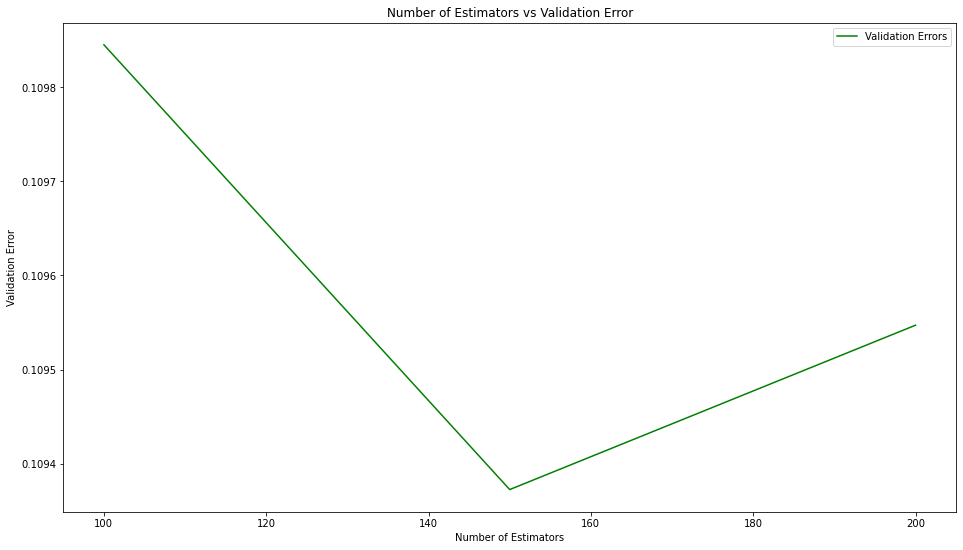

In [41]:
plt.figure(figsize=(16,9))
plt.plot(N,rf_val_errors, 'g-', label='Validation Errors')
plt.xlabel('Number of Estimators')
plt.ylabel('Validation Error')
plt.title('Number of Estimators vs Validation Error')
plt.legend()
plt.show()

In [42]:
idx = np.argmin(rf_val_errors)
rf = rf_models[idx]

In [43]:
cm = pd.crosstab(rf.predict(x_test_s).ravel(), y_test_s.values.ravel(),rownames=['pred'], colnames=['actual'])
cm

actual,0,1
pred,,
0,156711,19318
1,3516,29170


<a id="ada"></a>
## AdaBoost

Creating a list named eta of possible learning rates.

In [44]:
eta = np.arange(1,1.5,step=.1)

Empty lists to store the various models and their validation errors.

In [45]:
ada_models = []
ada_val_errors = []

Using cross-validation to determine the best learning rate.

In [47]:
for e in eta:
    ada = AdaBoost(learning_rate=e)
    ada.fit(x_train_s.values, y_train_s.values.ravel())
    ada_models.append(ada)
    ada_val_errors.append(1 - ada.score(x_val_s.values, y_val_s.values.ravel()))

Plotting the learning rates vs the errors produced from evaluating the model on the validation data. From the error values I used above it looks like 1.3 produces the lowest validation error.

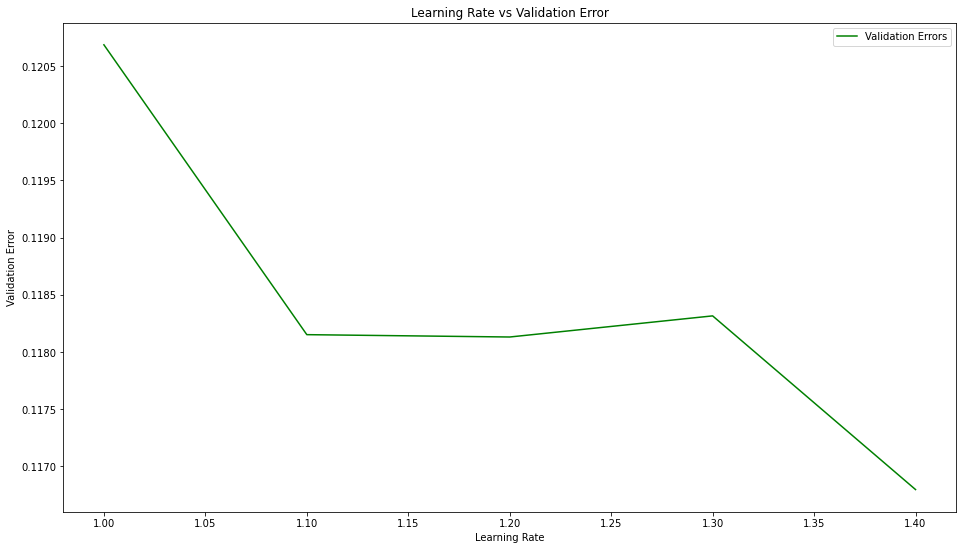

In [54]:
plt.figure(figsize=(16,9))
plt.plot(eta,ada_val_errors, 'g-', label='Validation Errors')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Error')
plt.title('Learning Rate vs Validation Error')
plt.legend()
plt.show()

Getting the model built with a learning rate of 1.3 to evaluate against the test data.

In [55]:
idx = np.argmin(ada_val_errors)
ada = ada_models[idx]

The confusion matrix produced from evaluating the model on the test data.

In [56]:
cm = pd.crosstab( ada.predict(x_test_s).ravel(), y_test_s.values.ravel(), rownames=['pred'], colnames=['actual'])
cm

actual,0,1
pred,,
0,156464,21394
1,3763,27094


<a id="svm"></a>
## Supprt Vector Machine

A list of possible values for the hyperparameter gamma.

In [57]:
# gamma = [True, False]

Empty lists to store the various models and another for their validation errors.

In [58]:
svm_models = []
svm_val_errors = []

Cross-validation to determine the best value for gamma.

In [59]:
# for g in gamma:
#     svm = BaggingClassifier(SVM(kernel = 'rbf', gamma=g))
svm = LinearSVC(dual=False)
svm.fit(x_train_s.values,y_train_s.values.ravel())
svm_models.append(svm)
svm_val_errors.append(1 - svm.score(x_val_s.values, y_val_s.values.ravel()))

Plotting gamma vs the validation error.

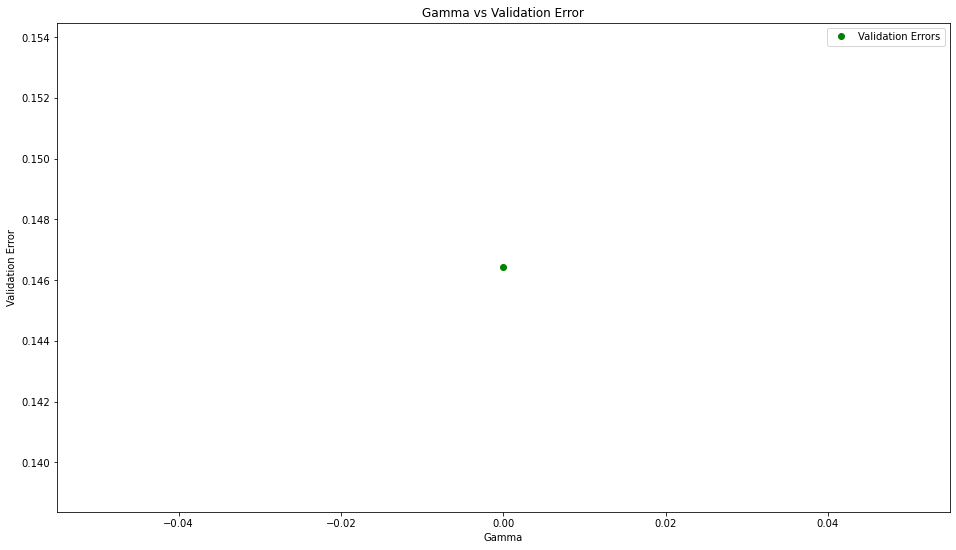

In [60]:
plt.figure(figsize=(16,9))
plt.plot([0], svm_val_errors, 'go', label='Validation Errors')
plt.xlabel('Gamma')
plt.ylabel('Validation Error')
plt.title('Gamma vs Validation Error')
plt.legend()
plt.show()

<a id="lr"></a>
## Logistic Regression

In [61]:
lr = LR(max_iter=1000)
lr.fit(x_train_n.values, y_train_n.values.ravel())

LogisticRegression(max_iter=1000)

In [62]:
cm = pd.crosstab( lr.predict(x_test_n).ravel(), y_test_n.values.ravel(), rownames=['pred'], colnames=['actual'])
cm

actual,0,1
pred,,
0,159510,30572
1,717,17916


In [63]:
accuracy_score(y_test_n, lr.predict(x_test_n))

0.8500874398102676

In [64]:
precision_score(y_test_n, lr.predict(x_test_n))

0.9615198840766382

In [65]:
print(recall_score(y_test_n, lr.predict(x_test_n)))
sens = cm[1][1] / (cm[1][1] + cm[1][0])
print(sens)

0.36949348292360995
0.36949348292360995


In [66]:
tnr = cm[0][0] / (cm[0][0]+cm[0][1])
tnr

0.9955250987661256

<a id="nn"></a>
## Neural Network

In [67]:
dataset_train = tf.data.Dataset.from_tensors((x_train_n, y_train_n))
dataset_val = tf.data.Dataset.from_tensors((x_val_n, y_val_n))
dataset_train.shuffle(5000)

<ShuffleDataset shapes: ((389600, 71), (389600, 1)), types: (tf.float64, tf.int64)>

In [68]:
def build_model():
    
    inputs = tf.keras.Input(shape=(x_train.shape[1]))
    dense_layer1 = keras.layers.Dense(16, activation=tf.nn.relu)
    x = dense_layer1(inputs)
    dropout_layer = keras.layers.Dropout(0.3)
    x = dropout_layer(x)
    predictions_layer = keras.layers.Dense(1, activation=tf.nn.sigmoid)
    predictions = predictions_layer(x)
    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy', 
                           tf.keras.metrics.Precision(0.7),
                           tf.keras.metrics.Recall(0.7)
                          ])
    return model

In [69]:
model = build_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 71)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                1152      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [70]:
num_epochs = tf.Variable(1000, dtype=tf.int64)
num_epochs

<tf.Variable 'Variable:0' shape=() dtype=int64, numpy=1000>

In [71]:
with tf.device('/gpu:0'):
    tf.keras.backend.clear_session()
    training_history = model.fit(dataset_train, epochs=num_epochs.value(), validation_data=dataset_val)

Epoch 1/1000
1/1 [==============================] - 0s 379ms/step - loss: 0.6344 - accuracy: 0.6631 - precision: 0.0667 - recall: 1.1013e-05 - val_loss: 0.5844 - val_accuracy: 0.7573 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.5930 - accuracy: 0.7344 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5563 - val_accuracy: 0.7682 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.5668 - accuracy: 0.7600 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5428 - val_accuracy: 0.7688 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.5564 - accuracy: 0.7655 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5411 - val_accuracy: 0.7688 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/1000
1/1 [=============================

1/1 [==============================] - 0s 44ms/step - loss: 0.4926 - accuracy: 0.7675 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4819 - val_accuracy: 0.7691 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 36/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.4905 - accuracy: 0.7677 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4797 - val_accuracy: 0.7691 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 37/1000
1/1 [==============================] - 0s 29ms/step - loss: 0.4887 - accuracy: 0.7678 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4777 - val_accuracy: 0.7692 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 38/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.4869 - accuracy: 0.7680 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4758 - val_accuracy: 0.7693 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 39/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 38ms/step - loss: 0.4382 - accuracy: 0.8397 - precision: 1.0000 - recall: 0.1566 - val_loss: 0.4219 - val_accuracy: 0.8516 - val_precision: 1.0000 - val_recall: 0.0824
Epoch 71/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.4374 - accuracy: 0.8402 - precision: 1.0000 - recall: 0.1705 - val_loss: 0.4211 - val_accuracy: 0.8516 - val_precision: 1.0000 - val_recall: 0.1119
Epoch 72/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.4368 - accuracy: 0.8452 - precision: 1.0000 - recall: 0.1806 - val_loss: 0.4202 - val_accuracy: 0.8517 - val_precision: 1.0000 - val_recall: 0.1469
Epoch 73/1000
1/1 [==============================] - 0s 30ms/step - loss: 0.4355 - accuracy: 0.8460 - precision: 0.9999 - recall: 0.1892 - val_loss: 0.4194 - val_accuracy: 0.8517 - val_precision: 1.0000 - val_recall: 0.1753
Epoch 74/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.4350 - accuracy: 0.8463 - precision: 1.000

Epoch 107/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.4147 - accuracy: 0.8503 - precision: 1.0000 - recall: 0.2673 - val_loss: 0.3985 - val_accuracy: 0.8518 - val_precision: 1.0000 - val_recall: 0.3580
Epoch 108/1000
1/1 [==============================] - 0s 48ms/step - loss: 0.4142 - accuracy: 0.8503 - precision: 1.0000 - recall: 0.2676 - val_loss: 0.3980 - val_accuracy: 0.8518 - val_precision: 1.0000 - val_recall: 0.3580
Epoch 109/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.4144 - accuracy: 0.8502 - precision: 1.0000 - recall: 0.2689 - val_loss: 0.3976 - val_accuracy: 0.8518 - val_precision: 1.0000 - val_recall: 0.3580
Epoch 110/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.4138 - accuracy: 0.8503 - precision: 1.0000 - recall: 0.2737 - val_loss: 0.3972 - val_accuracy: 0.8518 - val_precision: 1.0000 - val_recall: 0.3581
Epoch 111/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.4133 - accuracy: 0.8502

1/1 [==============================] - 0s 38ms/step - loss: 0.4040 - accuracy: 0.8506 - precision: 0.9998 - recall: 0.3268 - val_loss: 0.3875 - val_accuracy: 0.8517 - val_precision: 1.0000 - val_recall: 0.3590
Epoch 144/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.4030 - accuracy: 0.8507 - precision: 0.9997 - recall: 0.3263 - val_loss: 0.3873 - val_accuracy: 0.8518 - val_precision: 1.0000 - val_recall: 0.3590
Epoch 145/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.4037 - accuracy: 0.8506 - precision: 0.9996 - recall: 0.3261 - val_loss: 0.3871 - val_accuracy: 0.8518 - val_precision: 1.0000 - val_recall: 0.3590
Epoch 146/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.4029 - accuracy: 0.8507 - precision: 0.9996 - recall: 0.3270 - val_loss: 0.3869 - val_accuracy: 0.8518 - val_precision: 0.9999 - val_recall: 0.3590
Epoch 147/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.4029 - accuracy: 0.8506 - precision: 0

1/1 [==============================] - 0s 48ms/step - loss: 0.3978 - accuracy: 0.8508 - precision: 0.9990 - recall: 0.3272 - val_loss: 0.3822 - val_accuracy: 0.8519 - val_precision: 0.9986 - val_recall: 0.3594
Epoch 180/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.3978 - accuracy: 0.8507 - precision: 0.9990 - recall: 0.3271 - val_loss: 0.3821 - val_accuracy: 0.8518 - val_precision: 0.9986 - val_recall: 0.3594
Epoch 181/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.3976 - accuracy: 0.8507 - precision: 0.9989 - recall: 0.3271 - val_loss: 0.3821 - val_accuracy: 0.8518 - val_precision: 0.9986 - val_recall: 0.3594
Epoch 182/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.3977 - accuracy: 0.8507 - precision: 0.9989 - recall: 0.3276 - val_loss: 0.3818 - val_accuracy: 0.8518 - val_precision: 0.9986 - val_recall: 0.3594
Epoch 183/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3973 - accuracy: 0.8507 - precision: 0

1/1 [==============================] - 0s 34ms/step - loss: 0.3939 - accuracy: 0.8508 - precision: 0.9983 - recall: 0.3288 - val_loss: 0.3792 - val_accuracy: 0.8520 - val_precision: 0.9979 - val_recall: 0.3595
Epoch 216/1000
1/1 [==============================] - 0s 29ms/step - loss: 0.3937 - accuracy: 0.8508 - precision: 0.9984 - recall: 0.3288 - val_loss: 0.3790 - val_accuracy: 0.8520 - val_precision: 0.9979 - val_recall: 0.3595
Epoch 217/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.3935 - accuracy: 0.8508 - precision: 0.9982 - recall: 0.3295 - val_loss: 0.3790 - val_accuracy: 0.8520 - val_precision: 0.9979 - val_recall: 0.3595
Epoch 218/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.3940 - accuracy: 0.8508 - precision: 0.9985 - recall: 0.3283 - val_loss: 0.3789 - val_accuracy: 0.8521 - val_precision: 0.9979 - val_recall: 0.3595
Epoch 219/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3935 - accuracy: 0.8509 - precision: 0

1/1 [==============================] - 0s 39ms/step - loss: 0.3906 - accuracy: 0.8510 - precision: 0.9982 - recall: 0.3281 - val_loss: 0.3768 - val_accuracy: 0.8521 - val_precision: 0.9982 - val_recall: 0.3594
Epoch 252/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.3908 - accuracy: 0.8510 - precision: 0.9985 - recall: 0.3290 - val_loss: 0.3767 - val_accuracy: 0.8521 - val_precision: 0.9978 - val_recall: 0.3594
Epoch 253/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.3908 - accuracy: 0.8510 - precision: 0.9982 - recall: 0.3287 - val_loss: 0.3766 - val_accuracy: 0.8521 - val_precision: 0.9983 - val_recall: 0.3594
Epoch 254/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.3905 - accuracy: 0.8509 - precision: 0.9980 - recall: 0.3283 - val_loss: 0.3765 - val_accuracy: 0.8521 - val_precision: 0.9979 - val_recall: 0.3594
Epoch 255/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.3904 - accuracy: 0.8510 - precision: 0

1/1 [==============================] - 0s 31ms/step - loss: 0.3879 - accuracy: 0.8481 - precision: 0.9979 - recall: 0.3308 - val_loss: 0.3746 - val_accuracy: 0.8522 - val_precision: 0.9977 - val_recall: 0.3596
Epoch 288/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3878 - accuracy: 0.8480 - precision: 0.9979 - recall: 0.3304 - val_loss: 0.3747 - val_accuracy: 0.8522 - val_precision: 0.9977 - val_recall: 0.3596
Epoch 289/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3876 - accuracy: 0.8481 - precision: 0.9975 - recall: 0.3314 - val_loss: 0.3746 - val_accuracy: 0.8522 - val_precision: 0.9977 - val_recall: 0.3596
Epoch 290/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.3876 - accuracy: 0.8480 - precision: 0.9975 - recall: 0.3306 - val_loss: 0.3746 - val_accuracy: 0.8522 - val_precision: 0.9977 - val_recall: 0.3596
Epoch 291/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.3873 - accuracy: 0.8483 - precision: 0

1/1 [==============================] - 0s 45ms/step - loss: 0.3846 - accuracy: 0.8492 - precision: 0.9978 - recall: 0.3424 - val_loss: 0.3730 - val_accuracy: 0.8522 - val_precision: 0.9970 - val_recall: 0.3599
Epoch 324/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.3848 - accuracy: 0.8490 - precision: 0.9974 - recall: 0.3425 - val_loss: 0.3729 - val_accuracy: 0.8522 - val_precision: 0.9972 - val_recall: 0.3598
Epoch 325/1000
1/1 [==============================] - 0s 47ms/step - loss: 0.3846 - accuracy: 0.8492 - precision: 0.9975 - recall: 0.3426 - val_loss: 0.3729 - val_accuracy: 0.8523 - val_precision: 0.9972 - val_recall: 0.3599
Epoch 326/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.3846 - accuracy: 0.8491 - precision: 0.9972 - recall: 0.3427 - val_loss: 0.3729 - val_accuracy: 0.8522 - val_precision: 0.9974 - val_recall: 0.3598
Epoch 327/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.3843 - accuracy: 0.8491 - precision: 0

1/1 [==============================] - 0s 39ms/step - loss: 0.3814 - accuracy: 0.8491 - precision: 0.9977 - recall: 0.3495 - val_loss: 0.3715 - val_accuracy: 0.8525 - val_precision: 0.9974 - val_recall: 0.3599
Epoch 360/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.3816 - accuracy: 0.8495 - precision: 0.9973 - recall: 0.3506 - val_loss: 0.3714 - val_accuracy: 0.8524 - val_precision: 0.9977 - val_recall: 0.3598
Epoch 361/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.3818 - accuracy: 0.8490 - precision: 0.9981 - recall: 0.3498 - val_loss: 0.3714 - val_accuracy: 0.8525 - val_precision: 0.9974 - val_recall: 0.3600
Epoch 362/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3819 - accuracy: 0.8494 - precision: 0.9973 - recall: 0.3504 - val_loss: 0.3715 - val_accuracy: 0.8524 - val_precision: 0.9977 - val_recall: 0.3598
Epoch 363/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.3816 - accuracy: 0.8491 - precision: 0

1/1 [==============================] - 0s 54ms/step - loss: 0.3787 - accuracy: 0.8493 - precision: 0.9980 - recall: 0.3502 - val_loss: 0.3692 - val_accuracy: 0.8526 - val_precision: 0.9979 - val_recall: 0.3599
Epoch 396/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.3786 - accuracy: 0.8496 - precision: 0.9976 - recall: 0.3511 - val_loss: 0.3692 - val_accuracy: 0.8524 - val_precision: 0.9979 - val_recall: 0.3598
Epoch 397/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.3786 - accuracy: 0.8494 - precision: 0.9976 - recall: 0.3508 - val_loss: 0.3692 - val_accuracy: 0.8526 - val_precision: 0.9979 - val_recall: 0.3598
Epoch 398/1000
1/1 [==============================] - 0s 63ms/step - loss: 0.3783 - accuracy: 0.8494 - precision: 0.9975 - recall: 0.3507 - val_loss: 0.3691 - val_accuracy: 0.8525 - val_precision: 0.9979 - val_recall: 0.3598
Epoch 399/1000
1/1 [==============================] - 0s 27ms/step - loss: 0.3783 - accuracy: 0.8496 - precision: 0

1/1 [==============================] - 0s 28ms/step - loss: 0.3764 - accuracy: 0.8496 - precision: 0.9979 - recall: 0.3505 - val_loss: 0.3678 - val_accuracy: 0.8531 - val_precision: 0.9980 - val_recall: 0.3602
Epoch 432/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3766 - accuracy: 0.8498 - precision: 0.9971 - recall: 0.3509 - val_loss: 0.3676 - val_accuracy: 0.8525 - val_precision: 0.9983 - val_recall: 0.3599
Epoch 433/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.3762 - accuracy: 0.8496 - precision: 0.9977 - recall: 0.3509 - val_loss: 0.3673 - val_accuracy: 0.8527 - val_precision: 0.9980 - val_recall: 0.3600
Epoch 434/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.3761 - accuracy: 0.8496 - precision: 0.9978 - recall: 0.3508 - val_loss: 0.3673 - val_accuracy: 0.8528 - val_precision: 0.9980 - val_recall: 0.3601
Epoch 435/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.3758 - accuracy: 0.8499 - precision: 0

1/1 [==============================] - 0s 33ms/step - loss: 0.3742 - accuracy: 0.8501 - precision: 0.9972 - recall: 0.3508 - val_loss: 0.3657 - val_accuracy: 0.8527 - val_precision: 0.9984 - val_recall: 0.3600
Epoch 468/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.3742 - accuracy: 0.8499 - precision: 0.9971 - recall: 0.3511 - val_loss: 0.3657 - val_accuracy: 0.8529 - val_precision: 0.9983 - val_recall: 0.3602
Epoch 469/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.3739 - accuracy: 0.8499 - precision: 0.9974 - recall: 0.3509 - val_loss: 0.3656 - val_accuracy: 0.8528 - val_precision: 0.9984 - val_recall: 0.3601
Epoch 470/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.3735 - accuracy: 0.8500 - precision: 0.9973 - recall: 0.3517 - val_loss: 0.3655 - val_accuracy: 0.8529 - val_precision: 0.9984 - val_recall: 0.3601
Epoch 471/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.3737 - accuracy: 0.8499 - precision: 0

1/1 [==============================] - 0s 31ms/step - loss: 0.3723 - accuracy: 0.8499 - precision: 0.9973 - recall: 0.3511 - val_loss: 0.3642 - val_accuracy: 0.8532 - val_precision: 0.9982 - val_recall: 0.3602
Epoch 504/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.3719 - accuracy: 0.8505 - precision: 0.9970 - recall: 0.3519 - val_loss: 0.3641 - val_accuracy: 0.8528 - val_precision: 0.9983 - val_recall: 0.3601
Epoch 505/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3726 - accuracy: 0.8498 - precision: 0.9969 - recall: 0.3507 - val_loss: 0.3642 - val_accuracy: 0.8532 - val_precision: 0.9982 - val_recall: 0.3602
Epoch 506/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3723 - accuracy: 0.8501 - precision: 0.9960 - recall: 0.3509 - val_loss: 0.3642 - val_accuracy: 0.8528 - val_precision: 0.9983 - val_recall: 0.3601
Epoch 507/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.3724 - accuracy: 0.8498 - precision: 0

1/1 [==============================] - 0s 47ms/step - loss: 0.3704 - accuracy: 0.8503 - precision: 0.9963 - recall: 0.3515 - val_loss: 0.3625 - val_accuracy: 0.8531 - val_precision: 0.9982 - val_recall: 0.3602
Epoch 540/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3703 - accuracy: 0.8501 - precision: 0.9971 - recall: 0.3514 - val_loss: 0.3625 - val_accuracy: 0.8533 - val_precision: 0.9980 - val_recall: 0.3603
Epoch 541/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.3705 - accuracy: 0.8505 - precision: 0.9964 - recall: 0.3520 - val_loss: 0.3624 - val_accuracy: 0.8532 - val_precision: 0.9982 - val_recall: 0.3602
Epoch 542/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3706 - accuracy: 0.8502 - precision: 0.9967 - recall: 0.3516 - val_loss: 0.3625 - val_accuracy: 0.8533 - val_precision: 0.9980 - val_recall: 0.3603
Epoch 543/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3704 - accuracy: 0.8505 - precision: 0

1/1 [==============================] - 0s 32ms/step - loss: 0.3687 - accuracy: 0.8506 - precision: 0.9966 - recall: 0.3520 - val_loss: 0.3615 - val_accuracy: 0.8531 - val_precision: 0.9982 - val_recall: 0.3602
Epoch 576/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.3692 - accuracy: 0.8503 - precision: 0.9968 - recall: 0.3515 - val_loss: 0.3616 - val_accuracy: 0.8539 - val_precision: 0.9979 - val_recall: 0.3603
Epoch 577/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.3695 - accuracy: 0.8508 - precision: 0.9956 - recall: 0.3524 - val_loss: 0.3612 - val_accuracy: 0.8532 - val_precision: 0.9980 - val_recall: 0.3602
Epoch 578/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.3691 - accuracy: 0.8505 - precision: 0.9969 - recall: 0.3520 - val_loss: 0.3607 - val_accuracy: 0.8534 - val_precision: 0.9979 - val_recall: 0.3603
Epoch 579/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3688 - accuracy: 0.8504 - precision: 0

1/1 [==============================] - 0s 30ms/step - loss: 0.3675 - accuracy: 0.8506 - precision: 0.9963 - recall: 0.3518 - val_loss: 0.3594 - val_accuracy: 0.8535 - val_precision: 0.9979 - val_recall: 0.3603
Epoch 612/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.3674 - accuracy: 0.8506 - precision: 0.9959 - recall: 0.3518 - val_loss: 0.3593 - val_accuracy: 0.8534 - val_precision: 0.9979 - val_recall: 0.3603
Epoch 613/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.3672 - accuracy: 0.8505 - precision: 0.9958 - recall: 0.3519 - val_loss: 0.3593 - val_accuracy: 0.8536 - val_precision: 0.9979 - val_recall: 0.3603
Epoch 614/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.3672 - accuracy: 0.8506 - precision: 0.9959 - recall: 0.3517 - val_loss: 0.3592 - val_accuracy: 0.8535 - val_precision: 0.9979 - val_recall: 0.3603
Epoch 615/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.3669 - accuracy: 0.8504 - precision: 0

1/1 [==============================] - 0s 42ms/step - loss: 0.3664 - accuracy: 0.8513 - precision: 0.9950 - recall: 0.3526 - val_loss: 0.3588 - val_accuracy: 0.8533 - val_precision: 0.9979 - val_recall: 0.3603
Epoch 648/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.3669 - accuracy: 0.8504 - precision: 0.9965 - recall: 0.3508 - val_loss: 0.3589 - val_accuracy: 0.8542 - val_precision: 0.9978 - val_recall: 0.3606
Epoch 649/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.3669 - accuracy: 0.8512 - precision: 0.9949 - recall: 0.3523 - val_loss: 0.3589 - val_accuracy: 0.8533 - val_precision: 0.9979 - val_recall: 0.3603
Epoch 650/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.3667 - accuracy: 0.8503 - precision: 0.9969 - recall: 0.3518 - val_loss: 0.3587 - val_accuracy: 0.8541 - val_precision: 0.9978 - val_recall: 0.3606
Epoch 651/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.3664 - accuracy: 0.8510 - precision: 0

1/1 [==============================] - 0s 41ms/step - loss: 0.3647 - accuracy: 0.8514 - precision: 0.9943 - recall: 0.3528 - val_loss: 0.3569 - val_accuracy: 0.8536 - val_precision: 0.9978 - val_recall: 0.3605
Epoch 684/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.3648 - accuracy: 0.8510 - precision: 0.9958 - recall: 0.3525 - val_loss: 0.3570 - val_accuracy: 0.8543 - val_precision: 0.9977 - val_recall: 0.3607
Epoch 685/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.3647 - accuracy: 0.8513 - precision: 0.9953 - recall: 0.3526 - val_loss: 0.3570 - val_accuracy: 0.8536 - val_precision: 0.9979 - val_recall: 0.3605
Epoch 686/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.3649 - accuracy: 0.8509 - precision: 0.9961 - recall: 0.3517 - val_loss: 0.3569 - val_accuracy: 0.8544 - val_precision: 0.9977 - val_recall: 0.3607
Epoch 687/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.3646 - accuracy: 0.8516 - precision: 0

1/1 [==============================] - 0s 34ms/step - loss: 0.3631 - accuracy: 0.8513 - precision: 0.9950 - recall: 0.3528 - val_loss: 0.3553 - val_accuracy: 0.8545 - val_precision: 0.9978 - val_recall: 0.3607
Epoch 720/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.3632 - accuracy: 0.8514 - precision: 0.9940 - recall: 0.3533 - val_loss: 0.3553 - val_accuracy: 0.8540 - val_precision: 0.9978 - val_recall: 0.3607
Epoch 721/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.3630 - accuracy: 0.8510 - precision: 0.9952 - recall: 0.3524 - val_loss: 0.3553 - val_accuracy: 0.8546 - val_precision: 0.9977 - val_recall: 0.3609
Epoch 722/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.3632 - accuracy: 0.8517 - precision: 0.9944 - recall: 0.3538 - val_loss: 0.3553 - val_accuracy: 0.8541 - val_precision: 0.9978 - val_recall: 0.3607
Epoch 723/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.3634 - accuracy: 0.8513 - precision: 0

1/1 [==============================] - 0s 54ms/step - loss: 0.3623 - accuracy: 0.8512 - precision: 0.9956 - recall: 0.3527 - val_loss: 0.3541 - val_accuracy: 0.8546 - val_precision: 0.9975 - val_recall: 0.3609
Epoch 756/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.3620 - accuracy: 0.8517 - precision: 0.9942 - recall: 0.3538 - val_loss: 0.3538 - val_accuracy: 0.8542 - val_precision: 0.9977 - val_recall: 0.3609
Epoch 757/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.3616 - accuracy: 0.8515 - precision: 0.9948 - recall: 0.3531 - val_loss: 0.3537 - val_accuracy: 0.8543 - val_precision: 0.9975 - val_recall: 0.3609
Epoch 758/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.3618 - accuracy: 0.8516 - precision: 0.9945 - recall: 0.3536 - val_loss: 0.3537 - val_accuracy: 0.8544 - val_precision: 0.9975 - val_recall: 0.3609
Epoch 759/1000
1/1 [==============================] - 0s 30ms/step - loss: 0.3617 - accuracy: 0.8514 - precision: 0

1/1 [==============================] - 0s 30ms/step - loss: 0.3608 - accuracy: 0.8521 - precision: 0.9940 - recall: 0.3540 - val_loss: 0.3526 - val_accuracy: 0.8545 - val_precision: 0.9977 - val_recall: 0.3610
Epoch 792/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.3611 - accuracy: 0.8515 - precision: 0.9952 - recall: 0.3526 - val_loss: 0.3526 - val_accuracy: 0.8550 - val_precision: 0.9975 - val_recall: 0.3610
Epoch 793/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.3605 - accuracy: 0.8521 - precision: 0.9940 - recall: 0.3547 - val_loss: 0.3526 - val_accuracy: 0.8545 - val_precision: 0.9977 - val_recall: 0.3609
Epoch 794/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.3607 - accuracy: 0.8516 - precision: 0.9949 - recall: 0.3536 - val_loss: 0.3526 - val_accuracy: 0.8549 - val_precision: 0.9975 - val_recall: 0.3610
Epoch 795/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3604 - accuracy: 0.8519 - precision: 0

1/1 [==============================] - 0s 53ms/step - loss: 0.3598 - accuracy: 0.8521 - precision: 0.9939 - recall: 0.3542 - val_loss: 0.3520 - val_accuracy: 0.8544 - val_precision: 0.9977 - val_recall: 0.3609
Epoch 828/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.3599 - accuracy: 0.8516 - precision: 0.9952 - recall: 0.3535 - val_loss: 0.3519 - val_accuracy: 0.8554 - val_precision: 0.9972 - val_recall: 0.3611
Epoch 829/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3600 - accuracy: 0.8522 - precision: 0.9940 - recall: 0.3544 - val_loss: 0.3516 - val_accuracy: 0.8545 - val_precision: 0.9975 - val_recall: 0.3608
Epoch 830/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3596 - accuracy: 0.8517 - precision: 0.9954 - recall: 0.3540 - val_loss: 0.3513 - val_accuracy: 0.8552 - val_precision: 0.9972 - val_recall: 0.3611
Epoch 831/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3596 - accuracy: 0.8520 - precision: 0

1/1 [==============================] - 0s 34ms/step - loss: 0.3593 - accuracy: 0.8528 - precision: 0.9931 - recall: 0.3554 - val_loss: 0.3509 - val_accuracy: 0.8547 - val_precision: 0.9978 - val_recall: 0.3609
Epoch 864/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3589 - accuracy: 0.8519 - precision: 0.9949 - recall: 0.3534 - val_loss: 0.3505 - val_accuracy: 0.8556 - val_precision: 0.9972 - val_recall: 0.3611
Epoch 865/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.3587 - accuracy: 0.8523 - precision: 0.9930 - recall: 0.3548 - val_loss: 0.3501 - val_accuracy: 0.8550 - val_precision: 0.9974 - val_recall: 0.3611
Epoch 866/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.3584 - accuracy: 0.8520 - precision: 0.9944 - recall: 0.3540 - val_loss: 0.3499 - val_accuracy: 0.8554 - val_precision: 0.9972 - val_recall: 0.3611
Epoch 867/1000
1/1 [==============================] - 0s 30ms/step - loss: 0.3584 - accuracy: 0.8523 - precision: 0

1/1 [==============================] - 0s 44ms/step - loss: 0.3571 - accuracy: 0.8523 - precision: 0.9944 - recall: 0.3542 - val_loss: 0.3491 - val_accuracy: 0.8560 - val_precision: 0.9971 - val_recall: 0.3612
Epoch 900/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.3575 - accuracy: 0.8528 - precision: 0.9928 - recall: 0.3551 - val_loss: 0.3493 - val_accuracy: 0.8550 - val_precision: 0.9975 - val_recall: 0.3610
Epoch 901/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.3573 - accuracy: 0.8524 - precision: 0.9944 - recall: 0.3544 - val_loss: 0.3495 - val_accuracy: 0.8560 - val_precision: 0.9968 - val_recall: 0.3614
Epoch 902/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3577 - accuracy: 0.8528 - precision: 0.9926 - recall: 0.3553 - val_loss: 0.3498 - val_accuracy: 0.8547 - val_precision: 0.9978 - val_recall: 0.3609
Epoch 903/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.3577 - accuracy: 0.8521 - precision: 0

1/1 [==============================] - 0s 39ms/step - loss: 0.3563 - accuracy: 0.8526 - precision: 0.9940 - recall: 0.3546 - val_loss: 0.3478 - val_accuracy: 0.8560 - val_precision: 0.9969 - val_recall: 0.3613
Epoch 936/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.3562 - accuracy: 0.8530 - precision: 0.9931 - recall: 0.3553 - val_loss: 0.3478 - val_accuracy: 0.8556 - val_precision: 0.9972 - val_recall: 0.3611
Epoch 937/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3562 - accuracy: 0.8525 - precision: 0.9937 - recall: 0.3547 - val_loss: 0.3478 - val_accuracy: 0.8561 - val_precision: 0.9969 - val_recall: 0.3612
Epoch 938/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.3563 - accuracy: 0.8529 - precision: 0.9928 - recall: 0.3553 - val_loss: 0.3479 - val_accuracy: 0.8553 - val_precision: 0.9973 - val_recall: 0.3610
Epoch 939/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.3560 - accuracy: 0.8525 - precision: 0

1/1 [==============================] - 0s 39ms/step - loss: 0.3551 - accuracy: 0.8532 - precision: 0.9930 - recall: 0.3558 - val_loss: 0.3469 - val_accuracy: 0.8557 - val_precision: 0.9971 - val_recall: 0.3612
Epoch 972/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.3554 - accuracy: 0.8526 - precision: 0.9938 - recall: 0.3546 - val_loss: 0.3473 - val_accuracy: 0.8568 - val_precision: 0.9968 - val_recall: 0.3616
Epoch 973/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3553 - accuracy: 0.8531 - precision: 0.9925 - recall: 0.3561 - val_loss: 0.3477 - val_accuracy: 0.8552 - val_precision: 0.9974 - val_recall: 0.3610
Epoch 974/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.3557 - accuracy: 0.8526 - precision: 0.9946 - recall: 0.3541 - val_loss: 0.3478 - val_accuracy: 0.8570 - val_precision: 0.9966 - val_recall: 0.3618
Epoch 975/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.3560 - accuracy: 0.8533 - precision: 0

In [72]:
training_history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

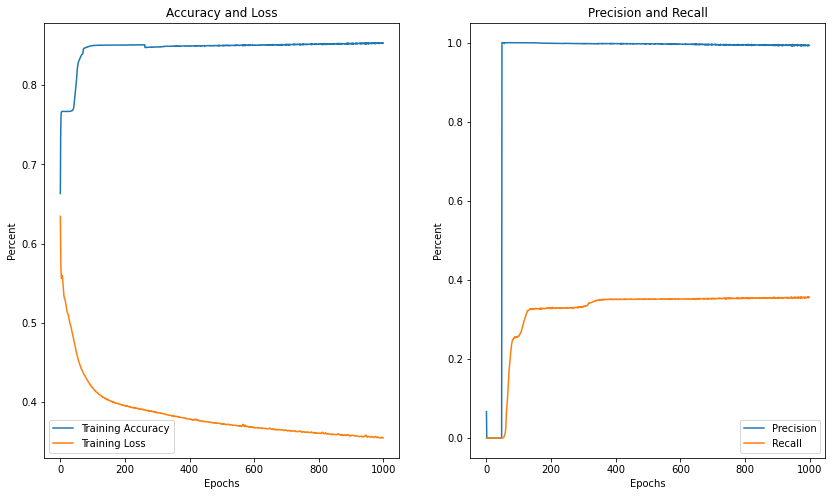

In [73]:
train_acc = training_history.history['accuracy']
train_loss = training_history.history['loss']

precision = training_history.history['precision']
recall = training_history.history['recall']

epochs_range = range(num_epochs.value())

plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
plt.xlabel('Epochs')
plt.ylabel('Percent')
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, train_loss, label='Training Loss')

plt.title('Accuracy and Loss')
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(epochs_range, precision, label='Precision')
plt.plot(epochs_range, recall, label='Recall')
plt.xlabel('Epochs')
plt.ylabel('Percent')
plt.title('Precision and Recall')
plt.legend()

In [79]:
with tf.device('/cpu:0'):
    score = model.evaluate(x_test_n, y_test_n)
    score_df = pd.Series(score, index = model.metrics_names)

score_df

6523/6523 [==============================] - 7s 1ms/step - loss: 0.3471 - accuracy: 0.8557 - precision: 0.9967 - recall: 0.3592


loss         0.347145
accuracy     0.855703
precision    0.996681
recall       0.359223
dtype: float64

In [80]:
y_pred = model.predict(x_test_n)
y_pred = np.where(y_pred>=0.7, 1, y_pred)
y_pred = np.where(y_pred<0.7, 0, y_pred)
pred_results = pd.DataFrame({'y_test': y_test_n.values.flatten().astype('int32'),
                             'y_pred': y_pred.flatten().astype('int32') }, index = range(len(y_pred)))
pred_results.sample(5)

,y_test,y_pred
115093,0,0
68798,0,0
191241,1,0
102498,0,0
200882,1,0


In [81]:
cm = pd.crosstab(pred_results.y_pred, pred_results.y_test)
cm

y_test,0,1
y_pred,,
0,160169,31070
1,58,17418


In [82]:
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(pred_results.y_test, pred_results.y_pred)
auc_mlp = auc(fpr_mlp, tpr_mlp)

<a id='roc'></a>
## ROC Curves

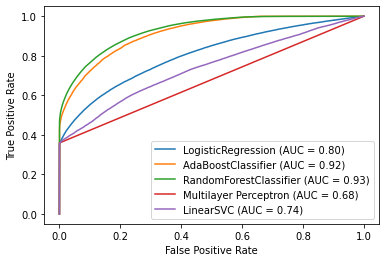

In [84]:
fig, ax = plt.subplots() 
plot_roc_curve(lr, x_test_n, y_test_n, ax=ax)
plot_roc_curve(ada, x_test_s, y_test_s, ax=ax)
plot_roc_curve(rf, x_test_s, y_test_s, ax=ax)
ax.plot(fpr_mlp, tpr_mlp, label='Multilayer Perceptron (AUC = {:.2f})'.format(auc_mlp))
plot_roc_curve(svm, x_test_n, y_test_n, ax=ax)
plt.legend()
plt.show()

<a id="unsupervised"></a>
# Unsupervised

## Gaussian Mixed Model

## K-Means

## Primary Component Analysis

## Kernel Primary Component Analysis